<a href="https://colab.research.google.com/github/arrxy/MRI-SuperResolution/blob/main/AMIR_SYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install nilearn pytorch_msssim

In [58]:
import cv2
import pdb
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import ipywidgets as widgets
import scipy.signal, scipy.misc
import plotly.graph_objects as go
import random
import base64
import io

from ipywidgets import interact, IntSlider, FloatSlider
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting, datasets, image, regions
from nilearn.connectome import ConnectivityMeasure
from nilearn.decoding import Decoder
from nilearn.image import mean_img, index_img
from nilearn.datasets import MNI152_FILE_PATH, load_mni152_template
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_glass_brain, view_img_on_surf, plot_epi, show, plot_roi, view_img
from nibabel.testing import data_path
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.model_selection import LeaveOneGroupOut
from skimage import data
from skimage.color import rgb2gray
from math import *
from pathlib import Path
from PIL import Image

import torch
import torch.fft as fft
import torch.nn.functional as F
import math
from torch import nn
from torch.utils.data import DataLoader
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from scipy.ndimage import gaussian_filter
from google.colab import drive
from torch.utils.data import Dataset
from einops import rearrange


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
drive.mount('/content/drive')
!mkdir -p /content/data
!cp -r /content/drive/MyDrive/mri/mri_data/train/ /content/data/train
!cp -r /content/drive/MyDrive/mri/mri_data/test/ /content/data/test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
## DATA
train_data_path = "/content/data/train"
test_data_path = "/content/data/test"
import os

train_data_og_pair_paths = []
train_data_syn1_pair_paths = []
train_data_syn2_pair_paths = []
train_data_syn3_pair_paths = []
hq_dir = os.path.join(train_data_path, "HQ_NII_VOLUMES")
lq_dir = os.path.join(train_data_path, "LQ_NII_VOLUMES")

hq_files = sorted(os.listdir(hq_dir))
lq_files = sorted(os.listdir(lq_dir))
lq_set = set(lq_files)

for hq_file in hq_files:
    if hq_file in lq_set:
        hf = os.path.join(hq_dir, hq_file)
        lf = os.path.join(lq_dir, hq_file)
        train_data_syn3_pair_paths.append([lf, hf])

for i in range(18):
    lf_og = os.path.join(
        train_data_path,
        "low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    lf_syn1 = os.path.join(
        train_data_path,
        "synthetic_low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    lf_syn2 = os.path.join(
        train_data_path,
        "physics_nii",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    hf = os.path.join(
        train_data_path,
        "high_field",
        f"sample_{i+1:03d}_highfield.nii"
    )

    train_data_og_pair_paths.append([lf_og, hf])
    train_data_syn1_pair_paths.append([lf_syn1, hf])
    train_data_syn2_pair_paths.append([lf_syn2, hf])

# for lf, hf in train_data_syn3_pair_paths:
#     print(os.path.exists(lf), os.path.exists(hf))

In [62]:
import os
import random

train_data_path = "/content/data/train"

# -------------------------
# Step 1: split original 18 scans
# -------------------------
scan_ids = [f"sample_{i+1:03d}" for i in range(18)]
random.seed(42)
random.shuffle(scan_ids)

train_ids = scan_ids[:15]
val_ids = scan_ids[15:17]
test_ids = scan_ids[17:18]

print("Train IDs:", train_ids)
print("Val IDs:", val_ids)
print("Test IDs:", test_ids)


# -------------------------
# Step 2: build pairs for real + syn1 + syn2
# -------------------------
def build_pairs(scan_list, use_synthetic=False):
    pairs = []
    for sid in scan_list:
        hf = os.path.join(train_data_path, "high_field", f"{sid}_highfield.nii")
        lf_real = os.path.join(train_data_path, "low_field", f"{sid}_lowfield.nii")

        if os.path.exists(lf_real):
            pairs.append([lf_real, hf])

        if use_synthetic:
            lf_syn1 = os.path.join(
                train_data_path, "synthetic_low_field", f"{sid}_lowfield.nii"
            )
            lf_syn2 = os.path.join(
                train_data_path, "physics_nii", f"{sid}_lowfield.nii"
            )

            if os.path.exists(lf_syn1):
                pairs.append([lf_syn1, hf])

            if os.path.exists(lf_syn2):
                pairs.append([lf_syn2, hf])

    return pairs


train_pairs = build_pairs(train_ids, use_synthetic=True)
val_pairs = build_pairs(val_ids, use_synthetic=False)
test_pairs = build_pairs(test_ids, use_synthetic=False)


# -------------------------
# Step 3: add syn3 pairs (400 random-named volumes)
# only to TRAIN set
# -------------------------
def build_syn3_pairs():
    pairs = []

    hq_dir = os.path.join(train_data_path, "HQ_NII_VOLUMES")
    lq_dir = os.path.join(train_data_path, "LQ_NII_VOLUMES")

    if not os.path.exists(hq_dir) or not os.path.exists(lq_dir):
        return pairs

    hq_files = sorted(os.listdir(hq_dir))
    lq_set = set(os.listdir(lq_dir))

    for hq_file in hq_files:
        if hq_file in lq_set:
            hf = os.path.join(hq_dir, hq_file)
            lf = os.path.join(lq_dir, hq_file)
            pairs.append([lf, hf])

    return pairs


syn3_pairs = build_syn3_pairs()
train_pairs += syn3_pairs


# -------------------------
# Step 4: summary
# -------------------------
print("\nDataset sizes:")
train_pairs = train_pairs[:200]
print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))
print("Test pairs:", len(test_pairs))
print("Syn3 added:", len(syn3_pairs))

Train IDs: ['sample_014', 'sample_013', 'sample_005', 'sample_010', 'sample_006', 'sample_008', 'sample_017', 'sample_007', 'sample_011', 'sample_016', 'sample_002', 'sample_012', 'sample_003', 'sample_015', 'sample_018']
Val IDs: ['sample_009', 'sample_001']
Test IDs: ['sample_004']

Dataset sizes:
Train pairs: 200
Val pairs: 2
Test pairs: 1
Syn3 added: 405


In [63]:
print(train_pairs)

[['/content/data/train/low_field/sample_014_lowfield.nii', '/content/data/train/high_field/sample_014_highfield.nii'], ['/content/data/train/synthetic_low_field/sample_014_lowfield.nii', '/content/data/train/high_field/sample_014_highfield.nii'], ['/content/data/train/physics_nii/sample_014_lowfield.nii', '/content/data/train/high_field/sample_014_highfield.nii'], ['/content/data/train/low_field/sample_013_lowfield.nii', '/content/data/train/high_field/sample_013_highfield.nii'], ['/content/data/train/synthetic_low_field/sample_013_lowfield.nii', '/content/data/train/high_field/sample_013_highfield.nii'], ['/content/data/train/physics_nii/sample_013_lowfield.nii', '/content/data/train/high_field/sample_013_highfield.nii'], ['/content/data/train/low_field/sample_005_lowfield.nii', '/content/data/train/high_field/sample_005_highfield.nii'], ['/content/data/train/synthetic_low_field/sample_005_lowfield.nii', '/content/data/train/high_field/sample_005_highfield.nii'], ['/content/data/train

In [64]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def load_nii(path):
    img = nib.load(path)
    return img.get_fdata()

def normalize_mri(volume):
    volume = volume.astype(np.float32)

    # percentile-based normalization
    p1 = np.percentile(volume, 1)
    p99 = np.percentile(volume, 99)

    volume = np.clip(volume, p1, p99)
    volume = (volume - p1) / (p99 - p1 + 1e-8)

    return volume

def resample_lr_to_hr(lr_path, hr_path):
    lr_img = nib.load(lr_path)
    hr_img = nib.load(hr_path)

    lr_vol = lr_img.get_fdata()
    hr_vol = hr_img.get_fdata()

    target_shape = hr_vol.shape

    zoom_factors = [
        target_shape[0] / lr_vol.shape[0],
        target_shape[1] / lr_vol.shape[1],
        target_shape[2] / lr_vol.shape[2],
    ]

    lr_resampled = zoom(lr_vol, zoom_factors, order=3)  # cubic

    return lr_resampled, hr_vol

In [65]:
class MRISagittalSliceDataset(Dataset):
    def __init__(self, pair_paths):
        self.samples = []

        for lf_path, hf_path in pair_paths:
            lr_vol, hr_vol = resample_lr_to_hr(lf_path, hf_path)

            lr_vol = normalize_mri(lr_vol)
            hr_vol = normalize_mri(hr_vol)

            assert lr_vol.shape == hr_vol.shape

            # sagittal slices
            for x in range(lr_vol.shape[0]):
                self.samples.append((
                    lr_vol[x, :, :],
                    hr_vol[x, :, :]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lr_slice, hr_slice = self.samples[idx]

        return (
            torch.from_numpy(lr_slice).float().unsqueeze(0),
            torch.from_numpy(hr_slice).float().unsqueeze(0)
        )

In [66]:
class Mlp(nn.Module):
    def __init__(self, in_feat, h_feat=None, out_feat=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_feat = out_feat or in_feat
        h_feat = h_feat or in_feat

        self.fc1 = nn.Linear(in_feat, h_feat)
        self.act = act_layer()
        self.fc2 = nn.Linear(h_feat, out_feat)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [67]:
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)


class WithBias_LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

In [68]:
class FeedForward(nn.Module):
    def __init__(self, dim, expansion, bias=False):
        super().__init__()
        hidden = int(dim * expansion)

        self.project_in = nn.Conv2d(dim, hidden * 2, 1, bias=bias)
        self.dwconv = nn.Conv2d(hidden * 2, hidden * 2, 3, 1, 1,
                                groups=hidden * 2, bias=bias)
        self.project_out = nn.Conv2d(hidden, dim, 1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        return self.project_out(x)

In [69]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim * 3, 1, bias=bias)
        self.qkv_dw = nn.Conv2d(dim * 3, dim * 3, 3, 1, 1,
                                groups=dim * 3, bias=bias)
        self.project = nn.Conv2d(dim, dim, 1, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape

        qkv = self.qkv_dw(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = attn @ v
        out = rearrange(out, 'b head c (h w) -> b (head c) h w',
                        head=self.num_heads, h=h, w=w)

        return self.project(out)

In [70]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, expansion):
        super().__init__()
        self.norm1 = LayerNorm(dim)
        self.attn = Attention(dim, heads)
        self.norm2 = LayerNorm(dim)
        self.ffn = FeedForward(dim, expansion)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

In [71]:
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_c, embed_dim, 3, 1, 1)

    def forward(self, x):
        return self.proj(x)

In [72]:
class Downsample(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(c, c // 2, 3, 1, 1),
            nn.PixelUnshuffle(2)
        )

    def forward(self, x):
        return self.body(x)


class Upsample(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(c, c * 2, 3, 1, 1),
            nn.PixelShuffle(2)
        )

    def forward(self, x):
        return self.body(x)

In [73]:
class AMIR(nn.Module):
    def __init__(
        self,
        inp_channels=1,
        out_channels=1,
        dim=48,
        num_blocks=[4, 6, 6, 8],
        heads=[1, 2, 4, 8],
        expansion=2.66
    ):
        super().__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        # Encoder
        self.enc1 = nn.Sequential(
            *[TransformerBlock(dim, heads[0], expansion)
              for _ in range(num_blocks[0])]
        )

        self.down1 = Downsample(dim)

        self.enc2 = nn.Sequential(
            *[TransformerBlock(dim * 2, heads[1], expansion)
              for _ in range(num_blocks[1])]
        )

        self.down2 = Downsample(dim * 2)

        self.enc3 = nn.Sequential(
            *[TransformerBlock(dim * 4, heads[2], expansion)
              for _ in range(num_blocks[2])]
        )

        self.down3 = Downsample(dim * 4)

        self.latent = nn.Sequential(
            *[TransformerBlock(dim * 8, heads[3], expansion)
              for _ in range(num_blocks[3])]
        )

        # Decoder
        self.up3 = Upsample(dim * 8)
        self.dec3 = TransformerBlock(dim * 4, heads[2], expansion)

        self.up2 = Upsample(dim * 4)
        self.dec2 = TransformerBlock(dim * 2, heads[1], expansion)

        self.up1 = Upsample(dim * 2)
        self.dec1 = TransformerBlock(dim, heads[0], expansion)

        self.output = nn.Conv2d(dim, out_channels, 3, 1, 1)

    def forward(self, x):
        inp = x

        x1 = self.patch_embed(x)
        x1 = self.enc1(x1)

        x2 = self.down1(x1)
        x2 = self.enc2(x2)

        x3 = self.down2(x2)
        x3 = self.enc3(x3)

        x4 = self.down3(x3)
        x4 = self.latent(x4)

        x = self.up3(x4) + x3
        x = self.dec3(x)

        x = self.up2(x) + x2
        x = self.dec2(x)

        x = self.up1(x) + x1
        x = self.dec1(x)

        out = self.output(x) + inp
        return out

In [74]:
class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.eps2 = epsilon * epsilon

    def forward(self, pred, target):
        diff = pred - target
        loss = torch.sqrt(diff * diff + self.eps2)
        return loss.mean()

def sobel_edges(x):
    sobel_x = torch.tensor(
        [[[-1,0,1],[-2,0,2],[-1,0,1]]],
        dtype=torch.float32,
        device=x.device
    ).unsqueeze(1)

    sobel_y = torch.tensor(
        [[[-1,-2,-1],[0,0,0],[1,2,1]]],
        dtype=torch.float32,
        device=x.device
    ).unsqueeze(1)

    gx = F.conv2d(x, sobel_x, padding=1)
    gy = F.conv2d(x, sobel_y, padding=1)

    return torch.sqrt(gx**2 + gy**2 + 1e-6)


class EdgeAwareLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()

    def forward(self, pred, target):
        return self.l1(sobel_edges(pred), sobel_edges(target))

charb = CharbonnierLoss()
edge = EdgeAwareLoss()

def total_loss(pred, target):
    return charb(pred, target) + 0.1 * edge(pred, target)

In [75]:
def compute_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    return 10 * math.log10(1.0 / mse.item())

In [76]:
model = AMIR(
    inp_channels=1,
    out_channels=1,
    dim=48
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100
)

In [77]:
import os

def train_model(model, train_loader, val_loader, epochs, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    best_psnr = 0

    for epoch in range(epochs):
        # -------------------------
        # Training
        # -------------------------
        model.train()
        train_loss = 0

        for lr, hr in train_loader:
            lr = lr.to(device)
            hr = hr.to(device)

            pred = model(lr)
            loss = total_loss(pred, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        val_psnr = 0

        with torch.no_grad():
            for lr, hr in val_loader:
                lr = lr.to(device)
                hr = hr.to(device)

                pred = model(lr)
                val_psnr += compute_psnr(pred, hr)

        val_psnr /= len(val_loader)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val PSNR: {val_psnr:.2f} dB\n")

        # -------------------------
        # Save best model
        # -------------------------
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            torch.save(
                model.state_dict(),
                os.path.join(save_dir, "best_model.pth")
            )
            print("Saved best model.")

In [78]:

train_dataset = MRISagittalSliceDataset(train_pairs)
val_dataset = MRISagittalSliceDataset(val_pairs)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))



Train samples: 35800
Val samples: 358


In [79]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [80]:
import torch.nn.functional as F

def pad_to_multiple(x, multiple=8):
    """
    x: tensor [B, C, H, W]
    """
    B, C, H, W = x.shape

    pad_h = (multiple - H % multiple) % multiple
    pad_w = (multiple - W % multiple) % multiple

    x = F.pad(x, (0, pad_w, 0, pad_h), mode="reflect")
    return x

In [81]:
lr, hr = next(iter(train_loader))
lr = lr.cuda()

lr = pad_to_multiple(lr)

out = model(lr)

print("Input:", lr.shape)
print("Output:", out.shape)

Input: torch.Size([4, 1, 224, 200])
Output: torch.Size([4, 1, 224, 200])


In [82]:
def train_model(model, train_loader, val_loader, epochs, save_dir, resume=True):
    import os
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_path = os.path.join(save_dir, "checkpoint.pth")
    best_model_path = os.path.join(save_dir, "best_model.pth")

    start_epoch = 0
    best_psnr = 0

    # -------------------------
    # Resume from checkpoint
    # -------------------------
    if resume and os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

        start_epoch = checkpoint["epoch"] + 1
        best_psnr = checkpoint["best_psnr"]
    else:
        print(f"Resumed from epoch {start_epoch}, best PSNR {best_psnr:.2f}")


    # -------------------------
    # Training loop
    # -------------------------
    for epoch in range(start_epoch, epochs):

        # -------------------------
        # Training
        # -------------------------
        model.train()
        train_loss = 0

        for i, (lr, hr) in enumerate(train_loader):
            lr = lr.to(device)
            hr = hr.to(device)

            lr = pad_to_multiple(lr)
            hr = pad_to_multiple(hr)

            pred = model(lr)
            loss = total_loss(pred, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            if i % 100 == 0:
              print(f"Epoch {epoch+1} | Batch {i}/{len(train_loader)} | Loss {loss.item():.4f}")

        train_loss /= len(train_loader)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        val_psnr = 0

        with torch.no_grad():
            for lr, hr in val_loader:
                lr = lr.to(device)
                hr = hr.to(device)

                lr = pad_to_multiple(lr)
                hr = pad_to_multiple(hr)

                pred = model(lr)
                val_psnr += compute_psnr(pred, hr)

        val_psnr /= len(val_loader)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val PSNR: {val_psnr:.2f} dB\n")

        # -------------------------
        # Save checkpoint (every epoch)
        # -------------------------
        if (epoch + 1) % 1 == 0:
            torch.save({
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_psnr": best_psnr
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        # -------------------------
        # Save best model
        # -------------------------
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            torch.save(model.state_dict(), best_model_path)
            print("Saved best model.")

In [83]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable params:", count_params(model))

Trainable params: 22250212


In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
save_dir = "/content/drive/MyDrive/amir_checkpoints_v2"
os.makedirs(save_dir, exist_ok=True)
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=60,
    save_dir=save_dir,
    resume=True
)

Loading checkpoint...
Epoch 25 | Batch 0/8950 | Loss 0.0277
Epoch 25 | Batch 100/8950 | Loss 0.0238
Epoch 25 | Batch 200/8950 | Loss 0.0120
Epoch 25 | Batch 300/8950 | Loss 0.0121
Epoch 25 | Batch 400/8950 | Loss 0.0169
Epoch 25 | Batch 500/8950 | Loss 0.0147
Epoch 25 | Batch 600/8950 | Loss 0.0308
Epoch 25 | Batch 700/8950 | Loss 0.0205
Epoch 25 | Batch 800/8950 | Loss 0.0333
Epoch 25 | Batch 900/8950 | Loss 0.0275
Epoch 25 | Batch 1000/8950 | Loss 0.0381
Epoch 25 | Batch 1100/8950 | Loss 0.0291
Epoch 25 | Batch 1200/8950 | Loss 0.0195
Epoch 25 | Batch 1300/8950 | Loss 0.0329
Epoch 25 | Batch 1400/8950 | Loss 0.0146
Epoch 25 | Batch 1500/8950 | Loss 0.0376
Epoch 25 | Batch 1600/8950 | Loss 0.0116
Epoch 25 | Batch 1700/8950 | Loss 0.0220
Epoch 25 | Batch 1800/8950 | Loss 0.0272
Epoch 25 | Batch 1900/8950 | Loss 0.0171
Epoch 25 | Batch 2000/8950 | Loss 0.0164
Epoch 25 | Batch 2100/8950 | Loss 0.0203
Epoch 25 | Batch 2200/8950 | Loss 0.0256
Epoch 25 | Batch 2300/8950 | Loss 0.0051
Epoch 

KeyboardInterrupt: 

In [86]:
import torch.nn.functional as F

def pad_to_multiple(x, multiple=2):
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple

    x = F.pad(x, (0, pad_w, 0, pad_h))
    return x, pad_h, pad_w

def remove_padding(x, pad_h, pad_w):
    if pad_h > 0:
        x = x[..., :-pad_h, :]
    if pad_w > 0:
        x = x[..., :, :-pad_w]
    return x

In [87]:
import torch.nn.functional as F

model.eval()

lr, hr = val_dataset[0]
lr = lr.unsqueeze(0).to(device)

print("Original shape:", lr.shape)

# FORCE pad to multiple of 8 (safe for AMIR)
_, _, h, w = lr.shape
pad_h = (8 - h % 8) % 8
pad_w = (8 - w % 8) % 8

lr = F.pad(lr, (0, pad_w, 0, pad_h))

print("After padding:", lr.shape)

with torch.no_grad():
    sr = model(lr)

Original shape: torch.Size([1, 1, 221, 200])
After padding: torch.Size([1, 1, 224, 200])


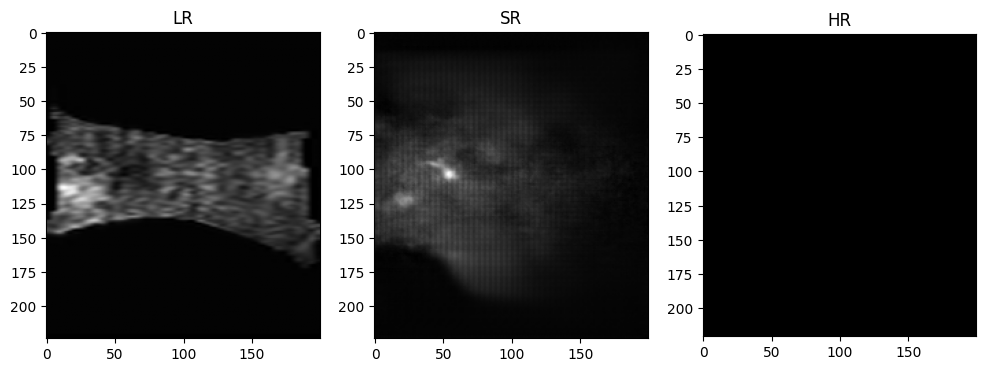

In [88]:
# move tensors to CPU and convert to numpy
lr = lr.detach().cpu().squeeze().numpy()
sr = sr.detach().cpu().squeeze().numpy()
hr = hr.detach().cpu().squeeze().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(lr, cmap="gray")
plt.title("LR")

plt.subplot(1,3,2)
plt.imshow(sr, cmap="gray")
plt.title("SR")

plt.subplot(1,3,3)
plt.imshow(hr, cmap="gray")
plt.title("HR")

plt.show()

In [89]:
import numpy as np
import torch.nn.functional as F

model.eval()

lf_path, hf_path = val_pairs[1]
lr_vol, hr_vol = resample_lr_to_hr(lf_path, hf_path)
lr_vol = normalize_mri(lr_vol)

sr_slices = []

with torch.no_grad():
    for x in range(lr_vol.shape[0]):
        lr_slice = lr_vol[x]

        lr_tensor = (
            torch.from_numpy(lr_slice)
            .float()
            .unsqueeze(0)
            .unsqueeze(0)
            .to(device)
        )

        # ---- FORCE padding to multiple of 8 ----
        _, _, h, w = lr_tensor.shape
        pad_h = (8 - h % 8) % 8
        pad_w = (8 - w % 8) % 8

        lr_tensor = F.pad(lr_tensor, (0, pad_w, 0, pad_h))

        # verify padding
        # print("Padded shape:", lr_tensor.shape)

        sr_tensor = model(lr_tensor)

        # remove padding
        if pad_h > 0:
            sr_tensor = sr_tensor[..., :-pad_h, :]
        if pad_w > 0:
            sr_tensor = sr_tensor[..., :, :-pad_w]

        sr_slice = sr_tensor.cpu().squeeze().numpy()
        sr_slices.append(sr_slice)

sr_vol = np.stack(sr_slices, axis=0)

In [90]:
import nibabel as nib

hr_nii = nib.load(hf_path)
affine = hr_nii.affine

sr_nii = nib.Nifti1Image(sr_vol, affine)
nib.save(sr_nii, "sr_output.nii")

print("Saved sr_output.nii")

Saved sr_output.nii


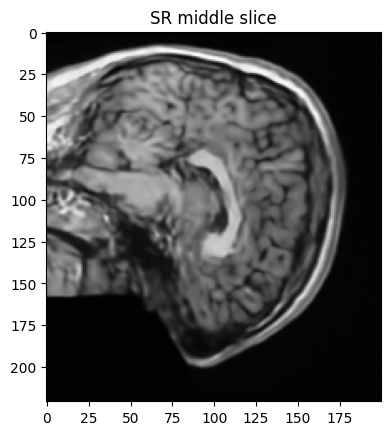

In [91]:
sr_loaded = nib.load("sr_output.nii").get_fdata()

slice_idx = sr_loaded.shape[0] // 2

plt.imshow(sr_loaded[slice_idx], cmap="gray")
plt.title("SR middle slice")
plt.show()

In [92]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load SR
sr_loaded = nib.load("sr_output.nii").get_fdata()

# Load LR and HR
lr_loaded = nib.load(lf_path).get_fdata()
hr_loaded = nib.load(hf_path).get_fdata()

In [93]:
slice_idx = sr_loaded.shape[0] // 2

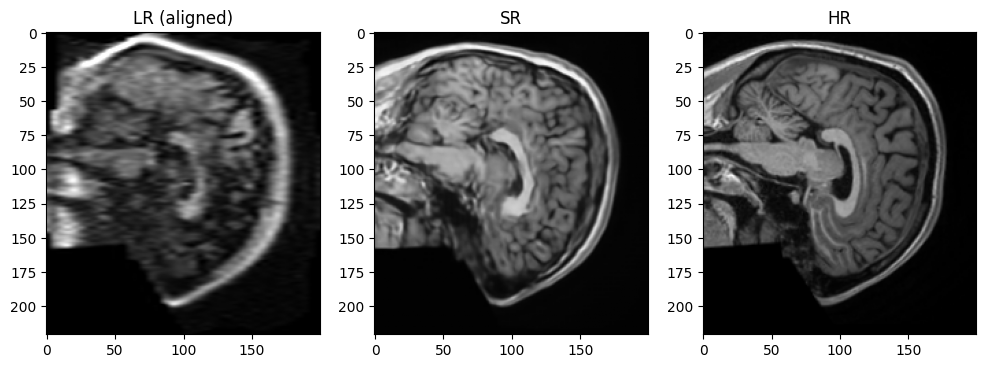

In [94]:
# get aligned volumes
lr_vol, hr_vol = resample_lr_to_hr(lf_path, hf_path)
lr_vol = normalize_mri(lr_vol)

sr_loaded = nib.load("sr_output.nii").get_fdata()

slice_idx = sr_loaded.shape[0] // 2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(lr_vol[slice_idx], cmap="gray")
plt.title("LR (aligned)")

plt.subplot(1,3,2)
plt.imshow(sr_loaded[slice_idx], cmap="gray")
plt.title("SR")

plt.subplot(1,3,3)
plt.imshow(hr_vol[slice_idx], cmap="gray")
plt.title("HR")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import random

# pick a random training sample
idx = random.randint(0, len(train_dataset) - 1)
print("Sample index:", idx)

lr, hr = train_dataset[idx]

# convert to numpy
lr = lr.squeeze().numpy()
hr = hr.squeeze().numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(lr, cmap="gray")
plt.title("LR (training sample)")

plt.subplot(1,2,2)
plt.imshow(hr, cmap="gray")
plt.title("HR (training sample)")

plt.show()

In [100]:
import numpy as np
import torch.nn.functional as F

model.eval()

_, hf_path = val_pairs[1]
lf_path = '/content/data/test/low_field/sample_019_lowfield.nii'
lr_vol, hr_vol = resample_lr_to_hr(lf_path, hf_path)
lr_vol = normalize_mri(lr_vol)

sr_slices = []

with torch.no_grad():
    for x in range(lr_vol.shape[0]):
        lr_slice = lr_vol[x]

        lr_tensor = (
            torch.from_numpy(lr_slice)
            .float()
            .unsqueeze(0)
            .unsqueeze(0)
            .to(device)
        )

        # ---- FORCE padding to multiple of 8 ----
        _, _, h, w = lr_tensor.shape
        pad_h = (8 - h % 8) % 8
        pad_w = (8 - w % 8) % 8

        lr_tensor = F.pad(lr_tensor, (0, pad_w, 0, pad_h))

        # verify padding
        # print("Padded shape:", lr_tensor.shape)

        sr_tensor = model(lr_tensor)

        # remove padding
        if pad_h > 0:
            sr_tensor = sr_tensor[..., :-pad_h, :]
        if pad_w > 0:
            sr_tensor = sr_tensor[..., :, :-pad_w]

        sr_slice = sr_tensor.cpu().squeeze().numpy()
        sr_slices.append(sr_slice)

sr_vol = np.stack(sr_slices, axis=0)

hr_nii = nib.load(hf_path)
affine = hr_nii.affine

sr_nii = nib.Nifti1Image(sr_vol, affine)
nib.save(sr_nii, "sample_019.nii")

print("sample_019_highfield.nii")

sample_019_highfield.nii


In [103]:
"""
Slice Extraction Utility for Low-Field to High-Field MRI Super-Resolution

This script provides standardized functions for:
1. Extracting all 200 axial slices from a 3D MRI volume
2. Encoding slices to base64 for CSV submission
3. Decoding base64 back to numpy arrays
4. Creating submission rows in the correct format

IMPORTANT: Use these functions to ensure your submissions match the expected format!

Submission format:
  - Each row represents one slice
  - row_id format: "sample_XXX_slice_YYY" (e.g., "sample_019_slice_100")
  - prediction: base64-encoded 2D slice (179 x 221 pixels)
"""

import numpy as np
import nibabel as nib
import base64
import io
import pandas as pd

# All 200 slices are used
NUM_SLICES = 200


def load_nifti(path):
    """
    Load a NIfTI file and return the data array.

    Args:
        path: Path to .nii.gz file

    Returns:
        3D numpy array (x, y, z)
    """
    img = nib.load(path)
    return img.get_fdata()


def slice_to_base64(slice_2d):
    """
    Encode a 2D slice to base64 string for CSV submission.

    The slice is normalized to uint8 (0-255) and compressed.
    Original value range is stored to allow reconstruction.

    Args:
        slice_2d: 2D numpy array

    Returns:
        Base64 encoded string
    """
    slice_min = float(slice_2d.min())
    slice_max = float(slice_2d.max())

    if slice_max - slice_min > 0:
        normalized = ((slice_2d - slice_min) / (slice_max - slice_min) * 255).astype(np.uint8)
    else:
        normalized = np.zeros_like(slice_2d, dtype=np.uint8)

    buffer = io.BytesIO()
    np.savez_compressed(buffer,
                        slice=normalized,
                        shape=np.array(slice_2d.shape),
                        min_val=np.array([slice_min]),
                        max_val=np.array([slice_max]))
    buffer.seek(0)

    return base64.b64encode(buffer.read()).decode('utf-8')


def base64_to_slice(b64_string):
    """
    Decode a base64 string back to a 2D numpy array.

    Args:
        b64_string: Base64 encoded string from slice_to_base64

    Returns:
        2D numpy array (float32)
    """
    buffer = io.BytesIO(base64.b64decode(b64_string))
    data = np.load(buffer)

    normalized = data['slice']
    min_val_arr = data['min_val']
    max_val_arr = data['max_val']

    # Handle both scalar and array storage formats
    min_val = float(min_val_arr.item()) if min_val_arr.ndim > 0 else float(min_val_arr)
    max_val = float(max_val_arr.item()) if max_val_arr.ndim > 0 else float(max_val_arr)

    if max_val - min_val > 0:
        original = normalized.astype(np.float32) / 255 * (max_val - min_val) + min_val
    else:
        original = np.zeros_like(normalized, dtype=np.float32)

    return original


def volume_to_submission_rows(volume, sample_id):
    """
    Convert a 3D volume to submission rows.

    Extracts all 200 axial slices and encodes them to base64.

    Args:
        volume: 3D numpy array with shape (179, 221, 200)
        sample_id: Sample identifier (e.g., "sample_019")

    Returns:
        List of dictionaries with keys: row_id, prediction
    """
    if volume.shape[2] != NUM_SLICES:
        raise ValueError(f"Volume must have {NUM_SLICES} slices in z-dimension, got {volume.shape[2]}")

    rows = []
    for slice_idx in range(NUM_SLICES):
        row_id = f"{sample_id}_slice_{slice_idx:03d}"
        slice_2d = volume[:, :, slice_idx]
        b64 = slice_to_base64(slice_2d)
        rows.append({"row_id": row_id, "prediction": b64})

    return rows


def create_submission_df(predictions_dict):
    """
    Create a submission DataFrame from a dictionary of predictions.

    Args:
        predictions_dict: Dictionary mapping sample_id to 3D volume
                         e.g., {"sample_019": volume_019, "sample_020": volume_020, ...}

    Returns:
        pandas DataFrame ready for submission
    """
    all_rows = []
    for sample_id, volume in predictions_dict.items():
        rows = volume_to_submission_rows(volume, sample_id)
        all_rows.extend(rows)

    return pd.DataFrame(all_rows)


def nifti_to_submission_rows(nifti_path, sample_id):
    """
    Load a NIfTI file and convert to submission rows.

    Args:
        nifti_path: Path to .nii.gz file
        sample_id: Sample identifier (e.g., "sample_019")

    Returns:
        List of dictionaries with keys: row_id, prediction
    """
    volume = load_nifti(nifti_path)
    return volume_to_submission_rows(volume, sample_id)

data = []
for row in range(5):
    id = 19 + row
    x = nifti_to_submission_rows(f"./sample_0{id:02d}.nii", f"sample_0{id:02d}")
    data.extend(x)
df = pd.DataFrame(data)
df.to_csv("submission_AMIR.csv", index=False)



In [ ]:
# Load SR
sr_loaded = nib.load("sample_019_highfield.nii").get_fdata()

# Load LR and HR
lr_loaded = nib.load(lf_path).get_fdata()
hr_loaded = nib.load(hf_path).get_fdata()
slice_idx = sr_loaded.shape[0] // 2
# get aligned volumes
lr_vol, hr_vol = resample_lr_to_hr(lf_path, hf_path)
lr_vol = normalize_mri(lr_vol)

sr_loaded = nib.load("sample_019_highfield.nii").get_fdata()

slice_idx = sr_loaded.shape[0] // 2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(lr_vol[slice_idx], cmap="gray")
plt.title("LR (aligned)")

plt.subplot(1,3,2)
plt.imshow(sr_loaded[slice_idx], cmap="gray")
plt.title("SR")

plt.subplot(1,3,3)
plt.imshow(hr_vol[slice_idx], cmap="gray")
plt.title("HR")

plt.show()